In [1]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
from utilsCPD import *
import matplotlib.pyplot as plt
import pandas as pd

In [213]:
def load_master_data(data_path="/datasets/has2023_master.csv.zip"):
    """
    Load the given CSV file containing the labelled challenge data.
    Returns a pandas DataFrame where each column is a sensor measurement
    or label and each row corresponds to a single time series.

    Parameters
    ----------
    data_path : str, default: "../datasets/has2023_master.csv.zip".
        Path to the csv file to be loaded.

    Returns
    -------
    pd.DataFrame
        DataFrame containing the sensor data for the challenge.

    Examples
    --------
    >>> data = load_master_data()
    >>> data.head()
    """
    np_cols = ["change_points", "activities", "x-acc", "y-acc", "z-acc",
               "x-gyro", "y-gyro", "z-gyro",
               "x-mag", "y-mag", "z-mag",
               "lat", "lon", "speed"]
    converters = {
        col: lambda val: np.array([]) if len(val) == 0 else np.array(eval(val)) for col
        in np_cols}
    return pd.read_csv(data_path, converters=converters, compression="zip")


def load_data(data_path="../datasets/has2023.csv.zip"):
    """
    Load the given CSV file containing the sensor data for the challenge.
    Returns a pandas DataFrame where each column is a sensor measurement and
    each row corresponds to a single time series of sensor data.

    Parameters
    ----------
    data_path : str, default: "../datasets/has2023.csv.zip".
        Path to the csv file to be loaded.

    Returns
    -------
    pd.DataFrame
        DataFrame containing the sensor data for the challenge.

    Examples
    --------
    >>> data = load_data()
    >>> data.head()
    """
    np_cols = ["x-acc", "y-acc", "z-acc",
               "x-gyro", "y-gyro", "z-gyro",
               "x-mag", "y-mag", "z-mag",
               "lat", "lon", "speed"]
    converters = {
        col: lambda val: np.array([]) if len(val) == 0 else np.array(eval(val)) for col
        in np_cols}
    return pd.read_csv(data_path, converters=converters, compression="zip")

In [219]:
df_TS = load_master_data("C:/Users/Sven Jacob/Downloads/has2023_master.csv.zip")
#df_TS = load_data("C:/Users/Sven Jacob/Downloads/has2023.csv.zip")

In [845]:
df_TS.iloc[249]

ts_id                                                            249
ts_challenge_id                                                   47
group                                                        outdoor
subject                                                            7
routine                                                            3
change_points                                                 [3533]
activities                                       [change break, run]
split                                                         public
x-acc              [-4.083903, -4.162383, -4.162383, -3.648058714...
y-acc              [1.3351410000000001, 1.570581, 1.570581, 1.374...
z-acc              [-9.160017428571429, -9.227286000000001, -9.22...
x-gyro                                                            []
y-gyro                                                            []
z-gyro                                                            []
x-mag              [-1.75, -1.6436

In [780]:
META_CPS = {}
##keys
keys = []
for i,cp in enumerate(df_TS['change_points']):
    if len(cp) not in keys:
        keys.append(len(cp))
        META_CPS[len(cp)] = []
    META_CPS[len(cp)].append(i)

META_CPS[2]

[5,
 11,
 19,
 20,
 23,
 47,
 48,
 50,
 54,
 62,
 63,
 64,
 65,
 66,
 68,
 69,
 73,
 74,
 76,
 80,
 86,
 98,
 104,
 110,
 112,
 113,
 114,
 115,
 116,
 117,
 135,
 159,
 161,
 162,
 163,
 184,
 201,
 206,
 208,
 209,
 215,
 219,
 227,
 228,
 229,
 231,
 232,
 233,
 237,
 238,
 239,
 242,
 243,
 247]

[1611 2979]


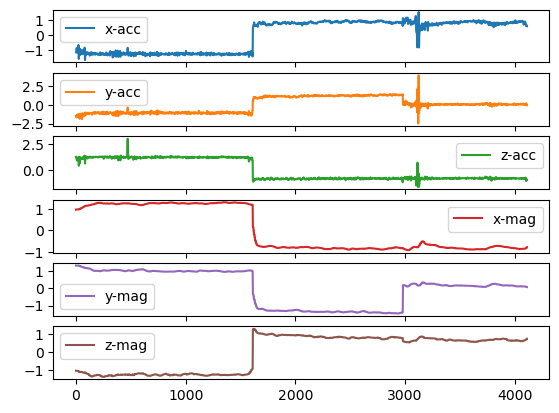

In [884]:

id = 243
channels_start = 8

initalized = False
for k,name in zip(df_TS.iloc[id,channels_start:],df_TS.columns[channels_start:]):
    #print(k)
    if np.array(k).shape[0]!=0:
        if not initalized:
            data = pd.DataFrame(k,columns=[name]).astype('float32')
            initalized = True
        else:
            data[name] = np.array(k).astype(np.float32)
if df_TS.iloc[id].group == 'outdoor':
    data = data.iloc[:,:-3]

data.head()

df_TS.iloc[id,1]

data = (data - data.mean())/data.std()
#data.describe()
data.iloc[:,:].plot(subplots=True)
GroundTruth = df_TS.iloc[id,5]
print(GroundTruth)

In [862]:
data.to_csv('HASC_TS_33.csv')

[1611 2979]


 34%|███▎      | 1218/3612 [00:02<00:03, 700.81it/s]

Change detected at: 1612 
 Initiate new segment


 70%|██████▉   | 2528/3612 [00:05<00:03, 334.57it/s]

Change detected at: 2980 
 Initiate new segment


100%|██████████| 3612/3612 [00:09<00:00, 398.15it/s]

F1 score: 1.0
Covering: 0.9990275069977558


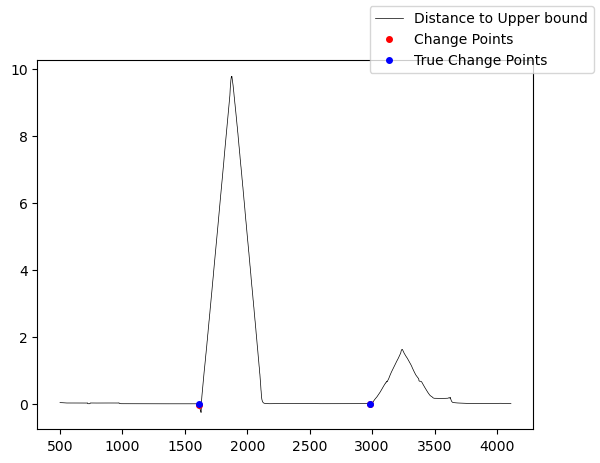

In [885]:
GroundTruth = df_TS.iloc[id,5]
print(GroundTruth)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
from tqdm import tqdm 
def gamma_conf_interval(step, a, b, confidence=0.95):
    alpha = step * a
    #lower_bound = gamma.ppf((1 - confidence), alpha, scale=b)
    upper_bound = gamma.ppf(1 - (1 - confidence), alpha, scale=b)
    return upper_bound

def CI_Calibration(alphas,betas,trend,significance=0.05):
    lookback = min(20,len(alphas))
    interval = np.arange(1,lookback+1,1)
    w = (1/np.sqrt(interval)**0)/np.sum(1/np.sqrt(interval)**0)
    a = np.mean(alphas[-lookback:])
    #a = np.average(alphas[-lookback:],weights=w)
    b = np.mean(betas[-lookback:])
    #b = np.average(betas[-lookback:],weights=w)
    return trend + gamma_conf_interval(1,a,1/b,1-significance)


loss_segments = []
alphas= []
betas =[]
LENGHT = 500
train_dataloader_ts = DataLoader(TimeseriesDataset(data.iloc[:,:].to_numpy(),LENGHT,split=0.5))
THETA = sample_theta_torch(data.iloc[:,:].to_numpy(), 5000)
TREND = []
cusum = 0
UPPER = []
LOWER = []
first = True
CPS = {'loc':[],'value':[]}
CUMSUM = []
for i, d in enumerate(tqdm(train_dataloader_ts)):
    #THETA = sample_theta_torch(df_sequential.to_numpy(), 5000)
    x_ref, x_cur = d[0].squeeze(0).to(device), d[1].squeeze(0).to(device)
    loss = project_and_calc_dist_torch(x_ref, x_cur, THETA, p=2, device=device).mean(axis=0).detach().cpu().numpy()
    loss_segments.append(loss)
    cusum += loss.mean()
    CUMSUM.append(cusum)
    if i>0:
        if cusum >= UPPER[-1]:
            if first == True:
                print("Change detected at: {} \n Initiate new segment".format(i+LENGHT))
                CPS['loc'].append(i+LENGHT)
                CPS['value'].append(UPPER[-1]-cusum)
                first = False
        else:
            if first == False:
                first = True
                #cusum = loss.mean()

    
    TREND.append(cusum)
    #k_lookback = min(len(TREND),1)
    #print(k_lookback)
    #parameter estimation
    a_hat, b_hat = mom_estimates(loss)
    alphas.append(a_hat)
    betas.append(b_hat)
    #calc next UPPERBOUND

    UPPER.append(CI_Calibration(alphas,betas,TREND[-1],significance=0.05))
    #LOWER.append(CI_Calibration(alphas,betas,TREND[-1],significance=0.05)[0])

print("F1 score: {}".format(f_measure({1:list(GroundTruth)},CPS['loc'],100)))
print("Covering: {}". format(covering({0:GroundTruth},CPS['loc'],data.shape[0])))


CUMSUM = np.cumsum([l.mean() for l in loss_segments])
fig, ax = plt.subplots()
t = np.arange(LENGHT+1,len(CUMSUM)+LENGHT,1)
ax.plot(t,np.subtract(UPPER[:-1],CUMSUM[1:]),label='Distance to Upper bound',color='black',alpha=1,lw=0.5)
ax.plot(np.array(CPS['loc']),CPS['value'],'o',color='red',ms=4,label='Change Points')
ax.plot(GroundTruth,np.zeros(len(GroundTruth)),'o',color='blue',ms=4,label='True Change Points')
fig.legend()

In [872]:
covering({0:GroundTruth},CPS['loc'],data.shape[0])

0.5857880308844248

In [ ]:
def true_positives(T, X, margin=5):
    """Compute true positives without double counting

    >>> true_positives({1, 10, 20, 23}, {3, 8, 20})
    {1, 10, 20}
    >>> true_positives({1, 10, 20, 23}, {1, 3, 8, 20})
    {1, 10, 20}
    >>> true_positives({1, 10, 20, 23}, {1, 3, 5, 8, 20})
    {1, 10, 20}
    >>> true_positives(set(), {1, 2, 3})
    set()
    >>> true_positives({1, 2, 3}, set())
    set()
    """
    # make a copy so we don't affect the caller
    X = set(list(X))
    TP = set()
    for tau in T:
        close = [(abs(tau - x), x) for x in X if abs(tau - x) <= margin]
        close.sort()
        if not close:
            continue
        dist, xstar = close[0]
        TP.add(tau)
        X.remove(xstar)
    return TP


def f_measure(annotations, predictions, margin=5, alpha=0.5, return_PR=False):
    """Compute the F-measure based on human annotations.

    annotations : dict from user_id to iterable of CP locations
    predictions : iterable of predicted CP locations
    alpha : value for the F-measure, alpha=0.5 gives the F1-measure
    return_PR : whether to return precision and recall too

    Remember that all CP locations are 0-based!

    >>> f_measure({1: [10, 20], 2: [11, 20], 3: [10], 4: [0, 5]}, [10, 20])
    1.0
    >>> f_measure({1: [], 2: [10], 3: [50]}, [10])
    0.9090909090909091
    >>> f_measure({1: [], 2: [10], 3: [50]}, [])
    0.8
    """
    # ensure 0 is in all the sets
    Tks = {k + 1: set(annotations[uid]) for k, uid in enumerate(annotations)}
    for Tk in Tks.values():
        Tk.add(0)

    X = set(predictions)
    X.add(0)

    Tstar = set()
    for Tk in Tks.values():
        for tau in Tk:
            Tstar.add(tau)

    K = len(Tks)

    P = len(true_positives(Tstar, X, margin=margin)) / len(X)

    TPk = {k: true_positives(Tks[k], X, margin=margin) for k in Tks}
    R = 1 / K * sum(len(TPk[k]) / len(Tks[k]) for k in Tks)

    F = P * R / (alpha * R + (1 - alpha) * P)
    if return_PR:
        return F, P, R
    return F


def overlap(A, B):
    """Return the overlap (i.e. Jaccard index) of two sets

    >>> overlap({1, 2, 3}, set())
    0.0
    >>> overlap({1, 2, 3}, {2, 5})
    0.25
    >>> overlap(set(), {1, 2, 3})
    0.0
    >>> overlap({1, 2, 3}, {1, 2, 3})
    1.0
    """
    return len(A.intersection(B)) / len(A.union(B))


def partition_from_cps(locations, n_obs):
    """Return a list of sets that give a partition of the set [0, T-1], as
    defined by the change point locations.

    >>> partition_from_cps([], 5)
    [{0, 1, 2, 3, 4}]
    >>> partition_from_cps([3, 5], 8)
    [{0, 1, 2}, {3, 4}, {5, 6, 7}]
    >>> partition_from_cps([1,2,7], 8)
    [{0}, {1}, {2, 3, 4, 5, 6}, {7}]
    >>> partition_from_cps([0, 4], 6)
    [{0, 1, 2, 3}, {4, 5}]
    """
    T = n_obs
    partition = []
    current = set()

    all_cps = iter(sorted(set(locations)))
    cp = next(all_cps, None)
    for i in range(T):
        if i == cp:
            if current:
                partition.append(current)
            current = set()
            cp = next(all_cps, None)
        current.add(i)
    partition.append(current)
    return partition


def cover_single(S, Sprime):
    """Compute the covering of a segmentation S by a segmentation Sprime.

    This follows equation (8) in Arbaleaz, 2010.

    >>> cover_single([{1, 2, 3}, {4, 5, 6}], [{1, 2, 3}, {4, 5}, {6}])
    0.8333333333333334
    >>> cover_single([{1, 2, 3, 4, 5, 6}], [{1, 2, 3, 4}, {5, 6}])
    0.6666666666666666
    >>> cover_single([{1, 2, 3}, {4, 5, 6}], [{1, 2}, {3, 4}, {5, 6}])
    0.6666666666666666
    >>> cover_single([{1}, {2}, {3}, {4, 5, 6}], [{1, 2, 3, 4, 5, 6}])
    0.3333333333333333
    """
    T = sum(map(len, Sprime))
    assert T == sum(map(len, S))
    C = 0
    for R in S:
        C += len(R) * max(overlap(R, Rprime) for Rprime in Sprime)
    C /= T
    return C


def covering(annotations, predictions, n_obs):
    """Compute the average segmentation covering against the human annotations.

    annotations : dict from user_id to iterable of CP locations
    predictions : iterable of predicted Cp locations
    n_obs : number of observations in the series

    >>> covering({1: [10, 20], 2: [10], 3: [0, 5]}, [10, 20], 45)
    0.7962962962962963
    >>> covering({1: [], 2: [10], 3: [40]}, [10], 45)
    0.7954144620811286
    >>> covering({1: [], 2: [10], 3: [40]}, [], 45)
    0.8189300411522634

    """
    Ak = {
        k + 1: partition_from_cps(annotations[uid], n_obs)
        for k, uid in enumerate(annotations)
    }
    pX = partition_from_cps(predictions, n_obs)

    Cs = [cover_single(Ak[k], pX) for k in Ak]
    return sum(Cs) / len(Cs)

In [277]:
np.sort(np.random.randint(0,len(data),len(GroundTruth)))

array([2480, 2874, 3020])

In [505]:
f_measure({1:list(GroundTruth)},[],100)

0.6666666666666666

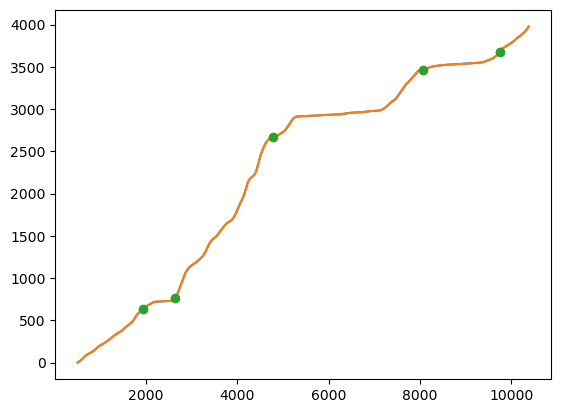

In [675]:

plt.plot(t,CUMSUM[1:])
plt.plot(t,UPPER[:-1])
plt.plot(GroundTruth,CUMSUM[GroundTruth-LENGHT],'o')

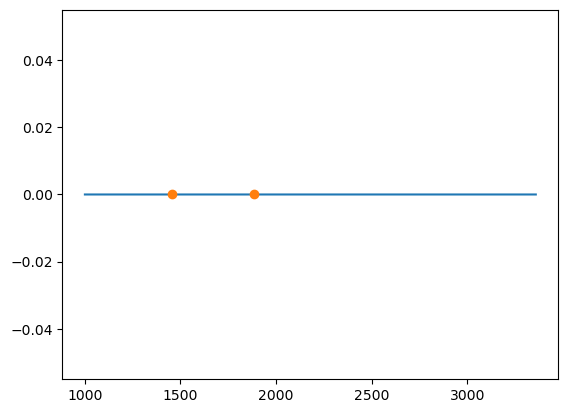

In [188]:
plt.plot(t,np.subtract(CUMSUM[1:],UPPER[:-1])>0)
plt.plot(GroundTruth,np.zeros(len(GroundTruth)),'o')

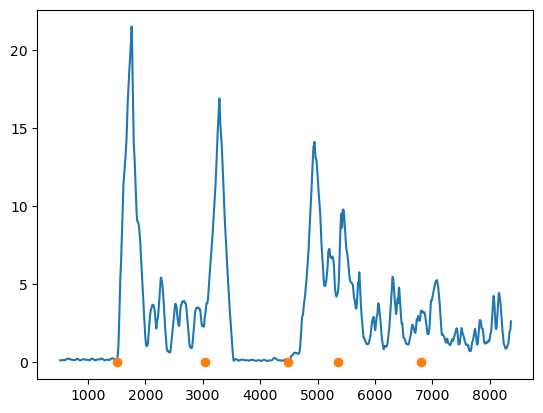

In [683]:
plt.plot(t,pd.Series(UPPER[:-1]).diff(10))
#plt.plot(t,pd.Series(LOWER[:-1]).diff())
plt.plot(GroundTruth,np.zeros(len(GroundTruth)),'o')

<Axes: >

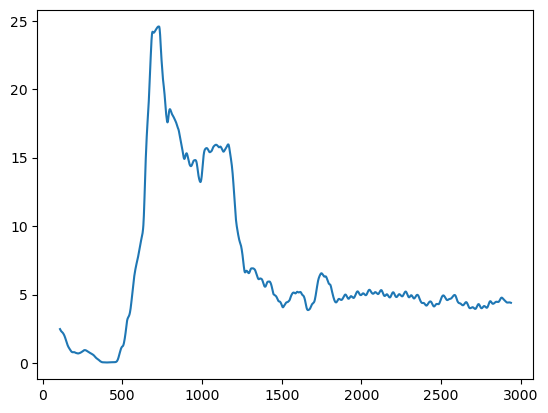

In [452]:
pd.Series(UPPER[:-1]).diff(10).rolling(100).mean().plot()

In [152]:
alpha_CI = [estimate_parameter_CI(l,0.05)[0] for l in loss_segments]
beta_CI = [estimate_parameter_CI(l,0.05)[1] for l in loss_segments]

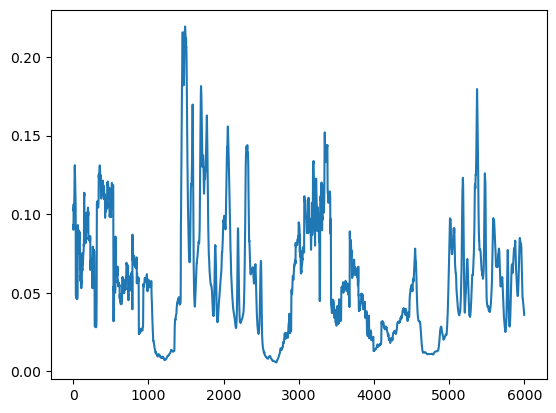

In [160]:
plt.plot(np.subtract(np.vstack(beta_CI)[:6000,1],np.vstack(beta_CI)[:6000,0]))

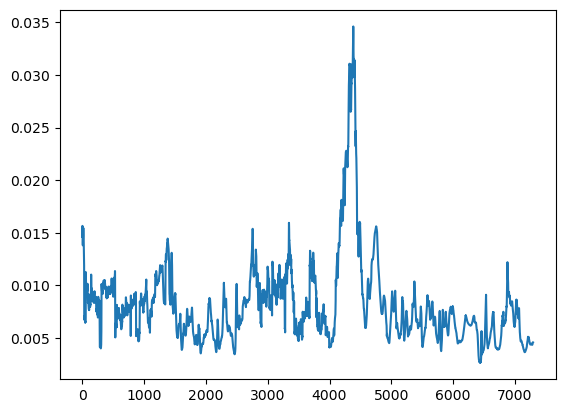

In [159]:
plt.plot(np.subtract(np.vstack(alpha_CI)[:,1],np.vstack(alpha_CI)[:,0]))

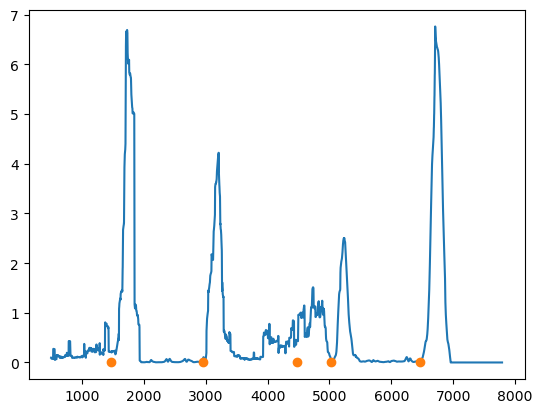

In [ ]:
plt.plot(t,[l.mean() for l in loss_segments[1:]])
plt.plot(GroundTruth,np.zeros(len(GroundTruth)),'o')